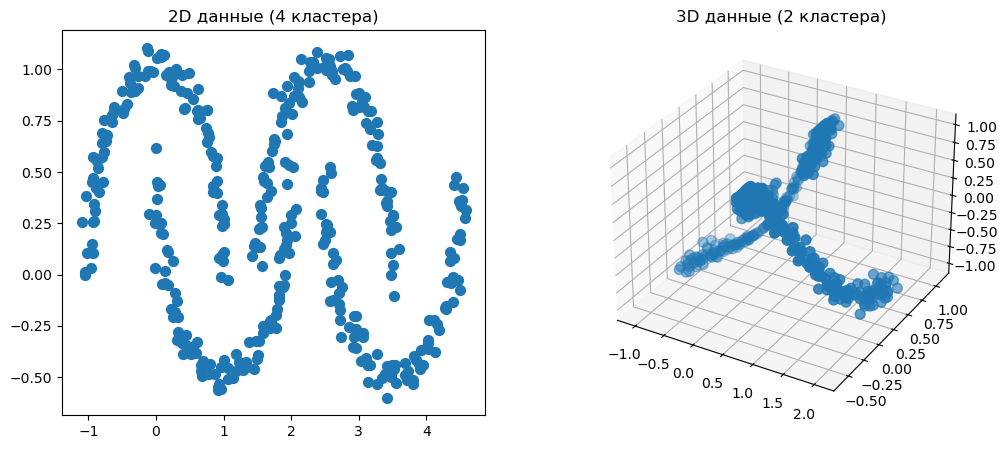

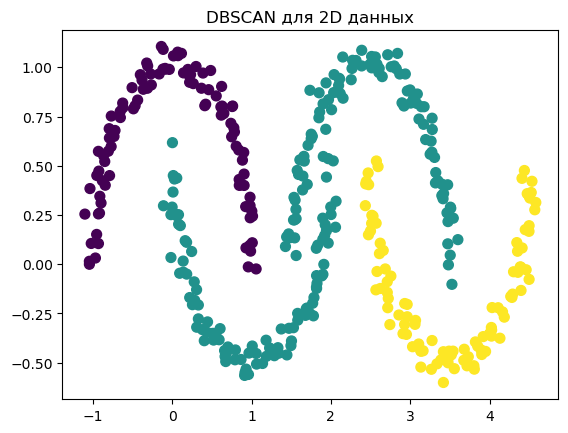

Силуэт: 0.26


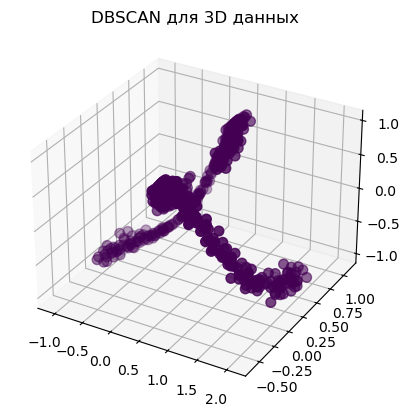

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

# Реализация алгоритма DBSCAN
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]
        visited = np.zeros(n_samples, dtype=bool)
        labels = np.full(n_samples, -1, dtype=int)
        cluster_id = 0

        for i in range(n_samples):
            if not visited[i]:
                visited[i] = True
                neighbors = self.region_query(X, i)
                if len(neighbors) < self.min_samples:
                    labels[i] = -1  # Шум
                else:
                    self.expand_cluster(X, i, neighbors, cluster_id, visited, labels)
                    cluster_id += 1
        self.labels_ = labels
        return self

    def expand_cluster(self, X, core_point_idx, neighbors, cluster_id, visited, labels):
        labels[core_point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            point_idx = neighbors[i]
            if not visited[point_idx]:
                visited[point_idx] = True
                new_neighbors = self.region_query(X, point_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors = np.concatenate([neighbors, new_neighbors])
            if labels[point_idx] == -1:
                labels[point_idx] = cluster_id
            i += 1

    def region_query(self, X, point_idx):
        distances = euclidean_distances([X[point_idx]], X).ravel()
        return np.where(distances <= self.eps)[0]

# Генерация данных
# 2D данные: 4 кластера (два набора лун)
X1, y1 = make_moons(n_samples=200, noise=0.05, random_state=42)
X2, y2 = make_moons(n_samples=200, noise=0.05, random_state=52)
X2 += np.array([2.5, 0])
X_2d = np.vstack([X1, X2])

# 3D данные: 2 кластера (луны в 3D)
X_circles, y_circles = make_moons(n_samples=500, noise=0.05, random_state=42)
X_3d = np.zeros((X_circles.shape[0], 3))
X_3d[:, :2] = X_circles
X_3d[:, 2] = np.sin(X_circles[:, 0] * 2)  # Нелинейное преобразование для третьего измерения

# Визуализация исходных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50)
plt.title("2D данные (4 кластера)")

ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], s=50)
plt.title("3D данные (2 кластера)")
plt.show()

# Применение DBSCAN и визуализация
def apply_dbscan(X, eps, min_samples, title):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)
    labels = dbscan.labels_

    # Визуализация
    if X.shape[1] == 2:
        plt.scatter(X[:,0], X[:,1], c=labels, s=50)
    else:
        ax = plt.figure().add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, s=50)
    plt.title(title)
    plt.show()

    # Оценка силуэтта
    mask = labels != -1
    if sum(mask) > 1:
        score = silhouette_score(X[mask], labels[mask])
        print(f"Силуэт: {score:.2f}")
    else:
        print("Недостаточно кластеров для оценки силуэтта")

# Параметры для 2D данных
apply_dbscan(X_2d, eps=0.3, min_samples=5, title="DBSCAN для 2D данных")
# Параметры для 3D данных
apply_dbscan(X_3d, eps=0.4, min_samples=10, title="DBSCAN для 3D данных")

# Сравнение с KMeans
def compare_with_kmeans(X, true_clusters):
    # Метод локтя
    wcss = []
    max_k = 10
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, max_k+1), wcss)
    plt.title("Метод локтя")
    plt.xlabel("Количество кластеров")
    plt.show()

    # Оценка силуэтта для оптимального k
    best_score = -1
    best_k = 1
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k

    print(f"Оптимальное k: {best_k}, силуэт: {best_score:.2f}")

    # Сравнение с DBSCAN
    dbscan = DBSCAN(eps=0.3 if X.shape[1]==2 else 0.4, 
                    min_samples=5 if X.shape[1]==2 else 10)
    dbscan.fit(X)
    dbscan_labels = dbscan.labels_
    mask = dbscan_labels != -1
    if sum(mask) > 1:
        dbscan_score = silhouette_score(X[mask], dbscan_labels[mask])
        print(f"DBSCAN силуэт: {dbscan_score:.2f}")
    else:
        print("DBSCAN не нашел кластеры")

print("Сравнение для 2D данных:")
compare_with_kmeans(X_2d, true_clusters=4)

print("\nСравнение для 3D данных:")
compare_with_kmeans(X_3d, true_clusters=2)